In [10]:
#THIS TRAINS A HYDROLOGICAL MODEL LOCALLY, USING ERA5 AND GLOFAS DATA TO PREDICT GLOFAS DATA
import sys
sys.path.append("../../")

#HYPERPARAMETERS
days_intake_length = 180
forecast_day = 30


In [17]:
#LIBRARY IMPORTS
from functions.floodmodels import shift_input, shift_test_inputs, reshape_scalar_predictand
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster
import seaborn as sns

#Connecting to a cluster to be able to run the code locally/on the cloud
client = Client()
#Use this line of code if you want to run the code on the cluster
# client = Client("tcp://169.45.50.121:8786")



/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [18]:
print(client.scheduler_info()['services'])


{'dashboard': 52278}


In [19]:
ds = xr.open_dataset('../../data/features_xy.nc')


In [20]:
ds

<xarray.Dataset>
Dimensions:     (time: 13514)
Coordinates:
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2017-12-31
Data variables:
    cp          (time) float32 ...
    lsp         (time) float32 ...
    swvl1       (time) float32 ...
    ro          (time) float32 ...
    sd          (time) float32 ...
    sd_diff     (time) float32 ...
    lsp-4-11    (time) float32 ...
    lsp-12-25   (time) float32 ...
    lsp-26-55   (time) float32 ...
    lsp-56-180  (time) float32 ...
    lsp-1       (time) float32 ...
    lsp-2       (time) float32 ...
    lsp-3       (time) float32 ...
    cp-1        (time) float32 ...
    cp-2        (time) float32 ...
    cp-3        (time) float32 ...
    dis         (time) float64 ...
    dis_diff    (time) float64 ...

In [21]:
#Selecting our X and y values from the dataset. Y has the river discharge values
y_orig = ds['dis_diff']
y = y_orig.copy()
X = ds.drop([ 'dis','lsp-4-11','lsp-26-55', 'lsp-12-25','lsp-56-180','cp-1','cp-2','cp-3','sd_diff', 'lsp-1','lsp-2','lsp-3'])


#Xda, yda = X.to_array(dim='features').T, y
Xda, yda = reshape_scalar_predictand(X, y)


mean: 0.0 , std: 4181.27897581471 , skew: 1100883.0967652714


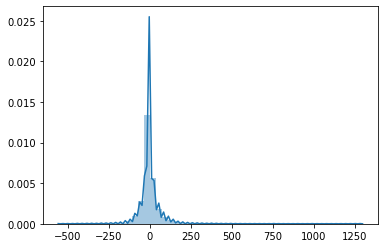

In [22]:
from scipy.stats import moment
dist = y.values.ravel() - y.mean().values.ravel() 
dist = dist[~np.isnan(dist)]
sns.distplot(dist)
print('mean:', moment(dist, 1), ', std:', moment(dist, 2), ', skew:', moment(dist, 3))

In [23]:
period_train = dict(time=slice(None, '2005'))
period_valid = dict(time=slice('2006', '2011'))
period_test = dict(time=slice('2012', '2016'))


X_train, y_train = Xda.loc[period_train], yda.loc[period_train]
X_valid, y_valid = Xda.loc[period_valid], yda.loc[period_valid]
X_test, y_test = Xda.loc[period_test], yda.loc[period_test]

In [24]:
import numpy as np

#Applying feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_train_scaled = sc.fit_transform(X_train)
sc2 = MinMaxScaler(feature_range=(0,1))
y_train_scaled = sc2.fit_transform(y_train.values.reshape(-1,1))

X_train_final, y_train_final = shift_input(X_train_scaled, y_train_scaled, days_intake_length, 1)
y_train_final = y_train_final.reshape(-1)

In [21]:
#Returns NaN values if you don't choose to use reshape_scalar_predictand

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.core import Dropout


regressor = Sequential()

regressor.add(LSTM(units=100, return_sequences= True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=100, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=100, return_sequences= True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=100))
regressor.add(Dropout(0.1))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

Using TensorFlow backend.
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/minico

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
history = regressor.fit(X_train_final, y_train_final, epochs=50, batch_size=32)

In [ ]:
#SAVING THE MODEL
regressor_yaml = regressor.to_yaml()
with open("../../models/sample-analysis/final-lstm.yaml", "w") as yaml_file:
    yaml_file.write(regressor_yaml)
# serialize weights to HDF5
regressor.save_weights("../../models/sample-analysis/final-lstm.h5")

In [5]:
#LATER ON...LOADING THE MODEL
regressor_model = open('../../models/sample-analysis/final-lstm.yaml', 'r').read()
from keras.models import model_from_yaml
loaded_regressor = model_from_yaml(regressor_model)
loaded_regressor.load_weights('../../models/sample-analysis/final-lstm.h5')
regressor = loaded_regressor


Using TensorFlow backend.
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/minico

Instructions for updating:
Colocations handled automatically by placer.


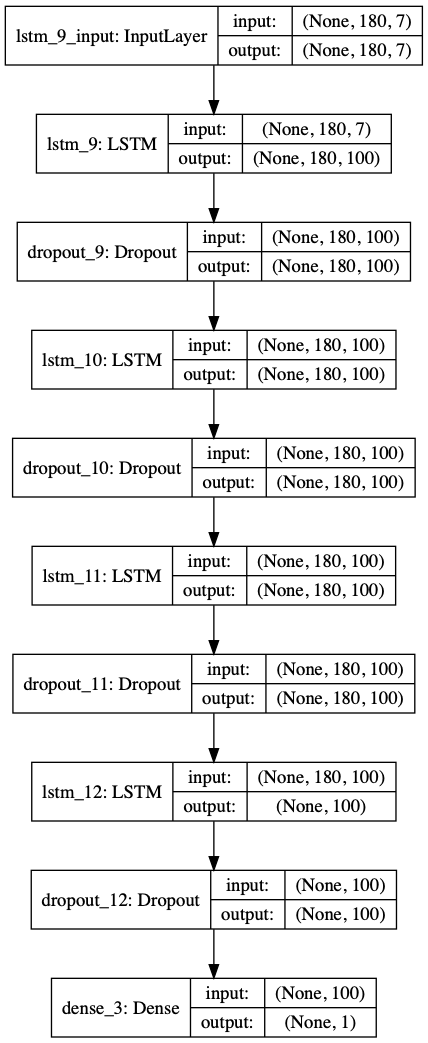

In [7]:
from keras.utils import plot_model
plot_model(regressor, to_file='../../images/pixel/model_architecture/model.png', show_shapes=True)

In [8]:
h = history

# Plot training & validation loss value
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(h.history['loss'], label='loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training'])
ax.set_yscale('log')

NameError: name 'history' is not defined

In [29]:
Xda.shape

(13119, 6)

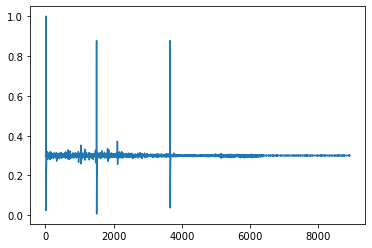

In [25]:
import matplotlib.pyplot as plt
plt.plot(regressor.predict(X_train_final))

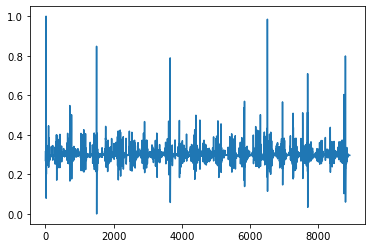

In [95]:
plt.plot(y_train_final)

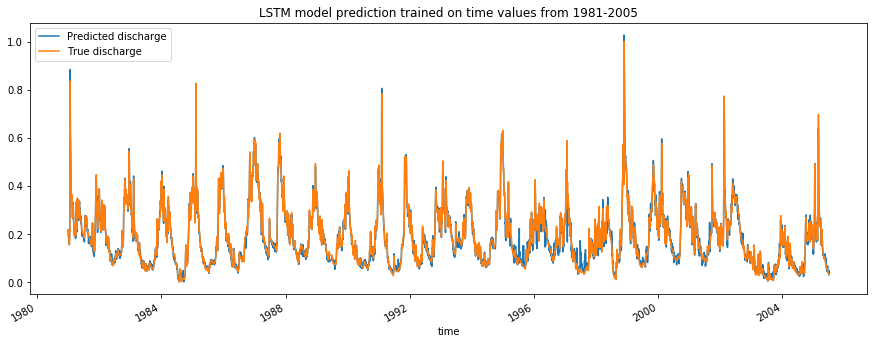

In [39]:
import matplotlib.pyplot as plt
y_pred_train = regressor.predict(X_train_final)
#Plotting the validation predicted values
y_pred_train_xr = xr.DataArray(y_pred_train.reshape(-1), dims=('time'), coords={'time': X_train.time.values[:-days_intake_length-1]})
y_pred_train_xr.plot(label = "Predicted discharge", figsize=(15,5))
#Plotting the real validation values
y_train_xr = xr.DataArray(y_train_final, dims=('time'), coords={'time': X_train.time.values[:-days_intake_length-1]})
y_train_xr.plot(label="True discharge")
plt.title('LSTM model prediction trained on time values from 1981-2005')
plt.legend(loc='upper left')

In [98]:
X_test_scaled = sc.transform(X_test)
y_test_scaled = sc2.transform(y_test.values.reshape(-1,1))

X_test_final, y_test_final = shift_input(X_test_scaled, y_test_scaled, days_intake_length, 1)
y_test_final = y_test_final.reshape(-1)

In [ ]:
y_pred_test = regressor.predict(X_test_final)

In [103]:
sc2.inverse_transform(y_pred_test.reshape(-1,1))

array([[10.17922  ],
       [ 9.763167 ],
       [ 9.008907 ],
       ...,
       [ 3.6087046],
       [ 4.199719 ],
       [ 4.454989 ]], dtype=float32)

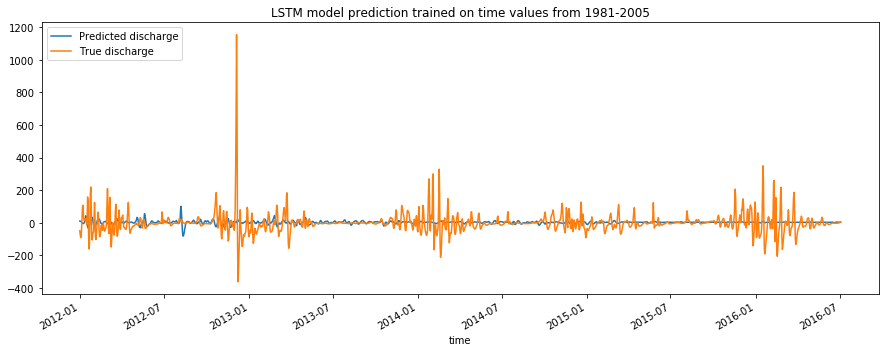

In [105]:
import matplotlib.pyplot as plt
#Plotting the validation predicted values
y_pred_test_xr = xr.DataArray(sc2.inverse_transform(y_pred_test.reshape(-1,1)).reshape(-1), dims=('time'), coords={'time': X_test.time.values[:-days_intake_length-1]})
y_pred_test_xr.plot(label = "Predicted discharge", figsize=(15,5))
#Plotting the real validation values
y_test_xr = xr.DataArray(sc2.inverse_transform(y_test_final.reshape(-1,1)).reshape(-1), dims=('time'), coords={'time': X_test.time.values[:-days_intake_length-1]})
y_test_xr.plot(label="True discharge")
plt.title('LSTM model prediction trained on time values from 1981-2005')
plt.legend(loc='upper left')

In [47]:
import eli5
from eli5.permutation_importance import get_score_importances

/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [128]:
def score_func(X, y):
        """Calculate the RMS error
        
        Parameters
        ----------
        xr.DataArrays
        """
        ypred = regressor.predict(X).reshape(-1)
        err_pred = ypred - y
        
        return np.sqrt(np.multiply(err_pred, err_pred))

In [129]:
score = score_func(X_test_final, y_test_final)

In [ ]:
base_score, score_decreases = get_score_importances(score_func, X_test_final, y_test_final, n_iter=5)
importances = score_decreases/np.max(score_decreases)  # normalize


In [2]:
score_decreases

NameError: name 'score_decreases' is not defined

In [78]:
from eli5.sklearn import PermutationImportance
import eli5
perm = PermutationImportance(regressor,n_iter=2).fit(X_train_final, y_train_final)
eli5.show_weights(perm, feature_names = X_train_final.columns.tolist())

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x140e365d0> does not.

In [ ]:
def feature_importance_plot(xda_features, importances):
    # xda_features : xr.DataArray.features
    # score_decreases : list of arrays
    mmin, mmed, mmax = np.min(importances, axis=0), np.median(importances, axis=0), np.max(importances, axis=0)
    
    labels = [e[0] for e in xda_features.values]
    assert len(labels) == len(importances[0])  # one label per entry
    plt.subplots(figsize=(15,5))

    x = np.arange(len(labels)) 
    plt.bar(x, mmed, yerr=(mmed-mmin, mmax-mmed), width = .8, ecolor='black', capsize=8)

    plt.xticks(ticks=x, labels=labels, rotation=20)
    plt.ylabel('normalized importance')
    plt.title('Estimate of Feature Importance by 5 row-wise Permutations')

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers.core import Dropout
from keras.constraints import MinMaxNorm, nonneg


def add_time(vector, time, name=None):
    """Converts numpy arrays to xarrays with a time coordinate.

    Parameters
    ----------
    vector : np.array
        1-dimensional array of predictions
    time : xr.DataArray
        the return value of `Xda.time`

    Returns
    -------
    xr.DataArray
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)


class DenseNN(object):
    def __init__(self, **kwargs):
        self.xscaler = StandardScaler()
        self.yscaler = StandardScaler()
        self.output_dim = 1
        
        model = keras.models.Sequential()
        self.cfg = kwargs
        hidden_nodes = self.cfg.get('hidden_nodes')
        
        model.add(keras.layers.Dense(hidden_nodes[0], 
                                     activation='tanh'))
        model.add(keras.layers.BatchNormalization())
        model.add(Dropout(self.cfg.get('dropout', None)))
        
        for n in hidden_nodes[1:]:
            model.add(keras.layers.Dense(n, activation='tanh')) 
            model.add(keras.layers.BatchNormalization())
            model.add(Dropout(self.cfg.get('dropout', None)))
        model.add(keras.layers.Dense(self.output_dim, 
                                     activation='linear'))
        opt = keras.optimizers.Adam() 

        model.compile(loss=self.cfg.get('loss'), optimizer=opt)
        self.model = model

        self.callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1e-2, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]
    
    def score_func(self, X, y):
        """Calculate the RMS error
        
        Parameters
        ----------
        xr.DataArrays
        """
        ypred = self.predict(X)
        err_pred = ypred - y
        
        # NaNs do not contribute to error
        err_pred = err_pred.where(~np.isnan(err_pred), 0.)  
        return float(np.sqrt(xr.dot(err_pred, err_pred)))
        
    def predict(self, Xda, name=None):
        """Input and Output: xr.DataArray
        
        Parameters
        ----------
        Xda : xr.DataArray
            with coordinates (time,)
        """
        X = self.xscaler.transform(Xda.values)
        y = self.model.predict(X).squeeze()
        y = self.yscaler.inverse_transform(y)
        
        y = add_time(y, Xda.time, name=name)
        return y

    def fit(self, X_train, y_train, X_valid, y_valid, **kwargs):
        """
        Input: xr.DataArray
        Output: None
        """
        
        print(X_train.shape)
        X_train = self.xscaler.fit_transform(X_train.values)
        y_train = self.yscaler.fit_transform(
                        y_train.values.reshape(-1, self.output_dim))
        
        X_valid = self.xscaler.transform(X_valid.values)
        y_valid = self.yscaler.transform(
                        y_valid.values.reshape(-1, self.output_dim))
        
        return self.model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid), 
                              epochs=self.cfg.get('epochs', 1000),
                              batch_size=self.cfg.get('batch_size'),
                              callbacks=self.callbacks,
                              verbose=0, **kwargs)
config = dict(hidden_nodes=(64,),  
                dropout=0.25,
                epochs=300,
                batch_size=90,
                loss='mse')

m = DenseNN(**config)
hist = m.fit(X_train, y_train, X_valid, y_valid)

(9101, 6)
Instructions for updating:
Use tf.cast instead.


/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/envs/flood_prediction/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


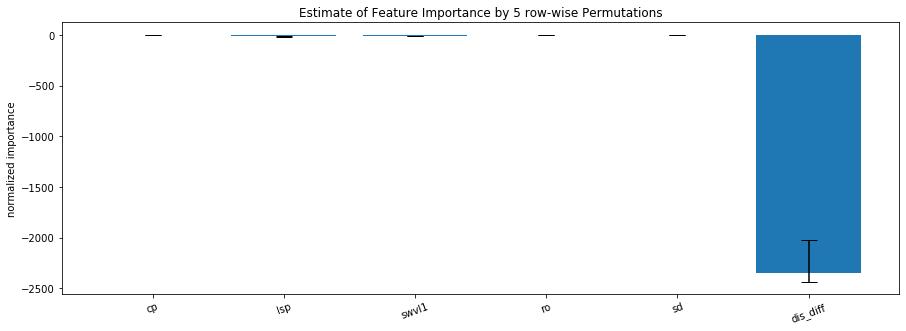

In [27]:
import eli5
from eli5.permutation_importance import get_score_importances
base_score, score_decreases = get_score_importances(m.score_func, X_test, y_test, n_iter=5)
importances = abs(score_decreases/np.max(score_decreases))  # normalize
def feature_importance_plot(xda_features, importances):
    # xda_features : xr.DataArray.features
    # score_decreases : list of arrays
    mmin, mmed, mmax = np.min(importances, axis=0), np.median(importances, axis=0), np.max(importances, axis=0)
    
    labels = [e[0] for e in xda_features.values]
    assert len(labels) == len(importances[0])  # one label per entry
    plt.subplots(figsize=(15,5))

    x = np.arange(len(labels)) 
    plt.bar(x, mmed, yerr=(mmed-mmin, mmax-mmed), width = .8, ecolor='black', capsize=8)

    plt.xticks(ticks=x, labels=labels, rotation=20)
    plt.ylabel('normalized importance')
    plt.title('Estimate of Feature Importance by 5 row-wise Permutations')
feature_importance_plot(Xda.features, importances)